In [1]:
import time

import pandas as pd # used to load the data
import numpy as np # optimized numerical library

from sklearn import preprocessing, metrics, utils, decomposition, model_selection, linear_model, discriminant_analysis, svm, tree, ensemble # library providing several ML algorithms and related utility
from sklearn.neural_network import MLPClassifier

from imblearn import over_sampling # provides several resampling techniques to cope with unbalanced datasets (https://github.com/scikit-learn-contrib/imbalanced-learn) compatible with sklearn

from collections import Counter

import matplotlib.pyplot as plt # used for plotting

# Start by defining three helper functions:
# - one to plot the sample distribution  acorss the class labels (to see how un-/balanced the dataset is)
# - one to compute and plot the confusion matrix
# - one to plot data in 2D with different colors per class label

def plot_pie(y, labels, title=""):
    target_stats = Counter(y)
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.set_title(title + " (size: %d)" % len(y))
    ax.pie(sizes, explode=explode, labels=target_stats.keys(), shadow=True, autopct='%1.1f%%')
    ax.axis('equal')


def compute_and_plot_cm(ytest, ypred, labels, title=""):
    global nfigure
    # Compute confusion matrix
    cm = metrics.confusion_matrix(ytest, ypred)
    
    accuracy = metrics.accuracy_score(ytest, ypred, normalize=True)

    # Normalize the matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    # Plot the confusion matrix

    nfigure = nfigure + 1
    plt.figure(nfigure) # new numbered figure
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues) # plot the confusionmatrix using blue shaded colors
    plt.title("Confusion Matrix Normalized (%s) Accuracy: %.1f%%" % (title, accuracy*100)) # add title
    plt.colorbar() # plot the color bar as legend

    # Plot the x and y ticks using the class label names
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)


def plot_2d(xpred, ypred, labels, title=""):
    global nfigure
    # define the colors to use for each class label
    colors = ['red', 'blue', 'green', 'yellow', 'black']
    len_colors = len(colors)
    if len_colors < len(labels):
        print("WARNING: we have less colors than classes: some classes will reuse the same color")

    nfigure = nfigure + 1
    plt.figure(nfigure) # new numbered figure
    plt.title("Feature Space (%s)" % title) # add title


    # plot each class label with a separate color 
    for c in range(len(labels)):
        cur_class = (ypred == c) # get all points belonging to class c
        plt.plot(xpred[cur_class, 0], xpred[cur_class, 1], 'o', color=colors[c % len_colors]) # plot class c


nfigure = 0 #used to number the figures

ModuleNotFoundError: No module named 'imblearn'

# 1. Loading the data

In [2]:
################ Load data ####################
# Get the dataset loaded 
file =  open("thermostat-train-data.txt","r")
train_x =  np.loadtxt(file)
print("train data shape:", train_x.shape)
file =  open("thermostat-train-labels.txt","r")
train_y =  np.loadtxt(file)
print("train label shape:", train_y.shape)
file =  open("thermostat-test-data.txt","r")
test_x =  np.loadtxt(file)
print("test data shape:", test_x.shape)
file =  open("thermostat-test-labels.txt","r")
test_y =  np.loadtxt(file)
print("test label shape:", test_y.shape)

train data shape: (82500, 115)
train label shape: (82500,)
test data shape: (27500, 115)
test label shape: (27500,)


### Lets make the data balance: over_sampling.SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

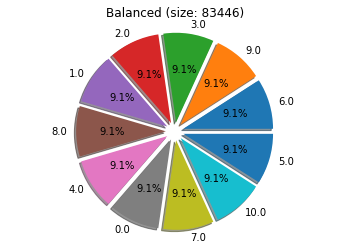

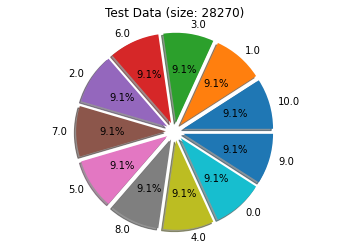

In [5]:
################ Resample data #################

# If the data is very skewed, try to balance the dataset
sm = over_sampling.SMOTE(random_state=42, ratio="auto")
train_x, train_y = sm.fit_sample(train_x, train_y)
data_class_labels = np.unique(train_y)

# Plot the balanced label distribution
plot_pie(train_y, data_class_labels, "Balanced")

# Do the same for test
sm = over_sampling.SMOTE(random_state=42, ratio="auto")
test_x, test_y = sm.fit_sample(test_x, test_y)
data_class_test = np.unique(test_y)


#Do the same for test
plot_pie(test_y, data_class_test, "Test Data")

# 2. Preparing the data

### Standardize the data

In [6]:
################ Scale data ####################
# Train a scaler to standardize the features (zero mean and unit variance)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# fit the data to find scale them and then trasnform them.
scaler.fit(train_x)
X_train_scaled = scaler.transform(train_x)
# Same for X_test.
scaler.fit(test_x)
X_test_scaled = scaler.transform(test_x)


In [7]:
X_train_scaled.shape

(83446, 115)

### Finding the 2 principle components (Bonus)

In [17]:
################ PCA ####################
# Train a PCA with 2 dimensions
pca = decomposition.PCA(n_components=2)

X_train_scaled_pca = pca.fit(train_x).transform(train_x)


X_test_scaled_pca = pca.fit(test_x).transform(test_x)
# ... and apply it to the features




In [18]:
X_test_scaled_pca.shape

(28270, 2)

# 3. Logistic Regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Acuracy of LR : 85.0%
[[9.97665370e-01 3.89105058e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.89105058e-04 0.00000000e+00 0.00000000e+00
  7.78210117e-04 0.00000000e+00 7.78210117e-04]
 [0.00000000e+00 9.63813230e-01 0.00000000e+00 0.00000000e+00
  3.57976654e-02 3.89105058e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.16731518e-03 0.00000000e+00 9.95719844e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.72373541e-03 3.89105058e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.98443580e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.55642023e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.00389105e-02 0.00000000e+00 0.00000000e+00
  9.19455253e-01 8.17120623e-03 0.00000000e+00 0.00000000e+00
  2.33463035e-03 0.00000000e+00 0.00000000e+00]
 [3.89105058e-04 3.89105058e-04 0.00000000e+00 0.00000000e+00
  3.89105058e-03 9.95330739e-01 0.00000000e+00 0.0000000

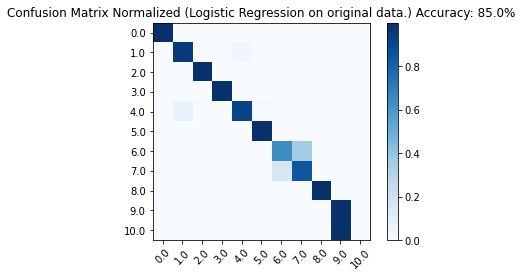

In [ ]:
################ Logit ##################

# Train a Logit model on the original features
lr = linear_model.LogisticRegression(penalty='none').fit(X_train_scaled, train_y)

# Compute the predicted labels on test data
y_lr = lr.predict(X_test_scaled)

# Print the accuracy
# test_y are the true test labels whereas y_lr are the predicted.
print("Acuracy of LR : %.1f%%" % (metrics.accuracy_score(test_y, y_lr)*100))

#Compute and print and confusion matrix

compute_and_plot_cm(test_y, y_lr,data_class_labels , title="Logistic Regression on original data.")

### Apply LR on PCA components (Bonus)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Acuracy of LR + PCA: 62.1%
[[9.67704280e-01 0.00000000e+00 0.00000000e+00 7.78210117e-04
  1.16731518e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.95719844e-02 7.78210117e-04 0.00000000e+00]
 [0.00000000e+00 1.26459144e-01 0.00000000e+00 0.00000000e+00
  7.52529183e-01 1.17120623e-01 0.00000000e+00 0.00000000e+00
  3.89105058e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.87159533e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.56031128e-03 4.28015564e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.71206226e-02 7.29571984e-01
  0.00000000e+00 0.00000000e+00 1.39688716e-01 1.12840467e-01
  3.89105058e-04 3.89105058e-04 0.00000000e+00]
 [0.00000000e+00 6.49805447e-02 0.00000000e+00 0.00000000e+00
  8.41634241e-01 8.75486381e-02 0.00000000e+00 0.00000000e+00
  5.83657588e-03 0.00000000e+00 0.00000000e+00]
 [1.16731518e-03 1.59922179e-01 0.00000000e+00 0.00000000e+00
  4.91828794e-01 3.23346304e-01 0.00000000e+00 0.00

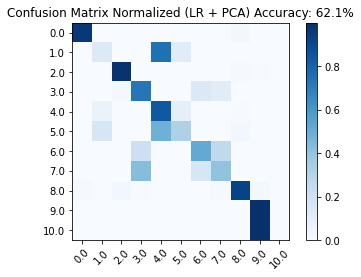

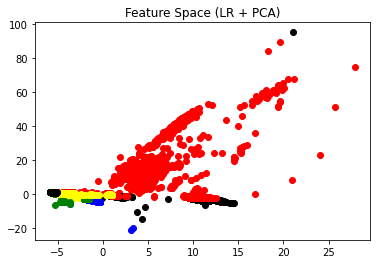

In [19]:
# Train a Logit model on pca extracted features
lr_pca = linear_model.LogisticRegression().fit(X_train_scaled_pca, train_y)

# Compute the predicted labels on test data
y_lr_pca = lr_pca.predict(X_test_scaled_pca)

# Prit the accuracy
print("Acuracy of LR + PCA: %.1f%%" % (metrics.accuracy_score(test_y,y_lr_pca)*100))


#Compute and print and confusion matrix
compute_and_plot_cm(test_y, y_lr_pca, data_class_labels, title="LR + PCA")

# visualize the predictions based on 2 PCA components
plot_2d(X_test_scaled_pca, y_lr_pca, data_class_labels, title="LR + PCA")

# 4. Apply Support Vector Machine

Acuracy of SVM: 86.6%
[[9.99221790e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  7.78210117e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.94552529e-01 0.00000000e+00 0.00000000e+00
  5.44747082e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.98443580e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.16731518e-03 0.00000000e+00 3.89105058e-04]
 [3.89105058e-04 0.00000000e+00 0.00000000e+00 9.99610895e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.89105058e-04 3.89105058e-04 0.00000000e+00 0.00000000e+00
  9.95330739e-01 3.89105058e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00 0.0000000

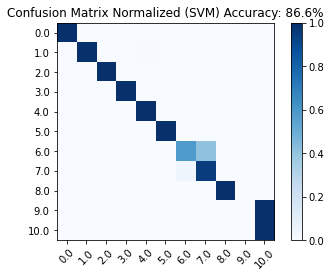

In [ ]:
################ SVM ##################
# Train a SVM model on the original features
sv = svm.SVC().fit(X_train_scaled,train_y)

# Compute the predicted labels on test data
y_sv = sv.predict(X_test_scaled)

# Print the accuracy
print("Acuracy of SVM: %.1f%%" % (metrics.accuracy_score(test_y,y_sv)*100))

#Compute and print and confusion matrix
compute_and_plot_cm(test_y, y_sv, data_class_labels, title="SVM")

# 5. Apply Decision Tree

In [ ]:
################ DecisionTree ##################
# Train a DT model on the original features
best_accuracy = float('-inf')
best_index = float('-inf')
for i in range(1,31):
    dt = tree.DecisionTreeClassifier(max_depth=i).fit(X_train_scaled,train_y)

    # Compute the predicted labels on test data
    y_dt = dt.predict(X_test_scaled)

    #print the accuracy
    accuracy = metrics.accuracy_score(test_y,y_dt)*100
    print("Acuracy of Decision Tree: {:.2f} with max_depth = {}".format(accuracy, i))
    # Compute and show confusion matrix
    if accuracy > best_accuracy: 
        best_accuracy = accuracy
        best_index = i  


Acuracy of Decision Tree: 18.18 with max_depth = 1
Acuracy of Decision Tree: 36.36 with max_depth = 2
Acuracy of Decision Tree: 54.48 with max_depth = 3
Acuracy of Decision Tree: 63.62 with max_depth = 4
Acuracy of Decision Tree: 72.71 with max_depth = 5
Acuracy of Decision Tree: 66.66 with max_depth = 6
Acuracy of Decision Tree: 68.73 with max_depth = 7
Acuracy of Decision Tree: 78.34 with max_depth = 8
Acuracy of Decision Tree: 70.13 with max_depth = 9
Acuracy of Decision Tree: 81.09 with max_depth = 10
Acuracy of Decision Tree: 70.36 with max_depth = 11
Acuracy of Decision Tree: 69.55 with max_depth = 12
Acuracy of Decision Tree: 67.70 with max_depth = 13
Acuracy of Decision Tree: 68.87 with max_depth = 14
Acuracy of Decision Tree: 76.62 with max_depth = 15
Acuracy of Decision Tree: 68.94 with max_depth = 16
Acuracy of Decision Tree: 77.79 with max_depth = 17
Acuracy of Decision Tree: 68.93 with max_depth = 18
Acuracy of Decision Tree: 67.81 with max_depth = 19
Acuracy of Decision T

best accuracy achieved with max_depth = 10 and it was equal to = 81.09
[[3.33073930e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 6.66926070e-01]
 [0.00000000e+00 9.99610895e-01 0.00000000e+00 0.00000000e+00
  3.89105058e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.99610895e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.89105058e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.99610895e-01
  0.00000000e+00 0.00000000e+00 3.89105058e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.000

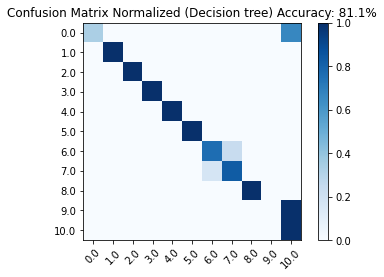

In [ ]:
print("best accuracy achieved with max_depth = {} and it was equal to = {:.2f}".format(best_index, best_accuracy))
dt = tree.DecisionTreeClassifier(max_depth=best_index).fit(X_train_scaled,train_y)

    # Compute the predicted labels on test data
y_dt = dt.predict(X_test_scaled)

compute_and_plot_cm(test_y, y_dt, data_class_labels, title="Decision tree")

# 6. Apply Random Forest

Acuracy of Random Forest: 81.76
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.89105058e-04 0.00000000e+00 9.99610895e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.99610895e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.89105058e-04
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00

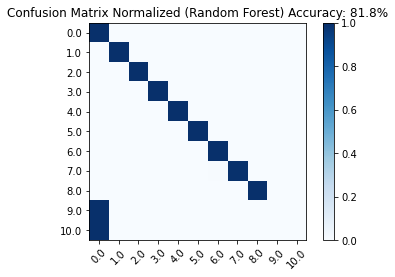

In [ ]:
################ RandomForest ##################
# Train a RF model on the original features
# default values for RandomForestClassifier.
rf = ensemble.RandomForestClassifier().fit(X_train_scaled,train_y)

# Compute the predicted labels on test data
y_rf = rf.predict(X_test_scaled)

#print the accuracy
accuracy = metrics.accuracy_score(test_y,y_rf)*100
print("Acuracy of Random Forest: {:.2f}".format(accuracy))
# Compute and show confusion matrix
compute_and_plot_cm(test_y, y_rf, data_class_labels, title="Random Forest")

#6b. Apply Random Forest with hyper-parameter tuning (RandomSearchCV)

In [ ]:
# n_estimators = number of trees in the foreset
# max_features = max number of features considered for splitting a node
# max_depth = max number of levels in each decision tree
# min_samples_split = min number of data points placed in a node before the node is split

# fine best parameters for random forest. 
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 210, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 15, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,15]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}
print(random_grid)


{'n_estimators': [100, 112, 124, 136, 148, 161, 173, 185, 197, 210], 'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, None], 'min_samples_split': [2, 5, 10, 15]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available coresrf_random.fit(X_train_scaled, train_x)
rf_random = RandomizedSearchCV( estimator = rf, param_distributions = random_grid, n_iter = 15, cv = 3, verbose=10, random_state=42, n_jobs = 8)
# Fit the random search model.
rf_random.fit(X_train_scaled, train_y)


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  3.9min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  6.7min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 10.3min
[Parallel(n_jobs=8)]: Done  35 out of  45 | elapsed: 13.0min remaining:  3.7min
[Parallel(n_jobs=8)]: Done  40 out of  45 | elapsed: 14.4min remaining:  1.8min
[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed: 15.0min remaining:    0.0s
[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed: 15.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_random.best_params_
#best parameters from random search CV.

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 124}

Acuracy of Random Forest: 81.21
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.89105058e-04 0.00000000e+00 9.99610895e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.89105058e-04 0.00000000e+00 0.00000000e+00 9.99610895e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.00000000e+00

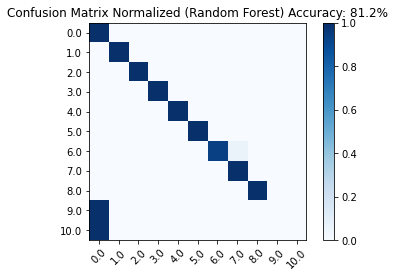

In [ ]:
# best params from randomsearchcv 

################ RandomForest ##################
# Train a RF model on the original features
# default values for RandomForestClassifier.
rf = ensemble.RandomForestClassifier(min_samples_split= 2, n_estimators= 124).fit(X_train_scaled,train_y)

# Compute the predicted labels on test data
y_rf = rf.predict(X_test_scaled)

#print the accuracy
accuracy = metrics.accuracy_score(test_y,y_rf)*100
print("Acuracy of Random Forest: {:.2f}".format(accuracy))
# Compute and show confusion matrix
compute_and_plot_cm(test_y, y_rf, data_class_labels, title="Random Forest")

# 7. Multi-Layer Perceptron (MLP)

Acuracy of Multi-layer Perceptron: 90.88
[[9.99610895e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.89105058e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.99610895e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.89105058e-04 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.99610895e-01
  3.89105058e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.00000000e+00 0.000

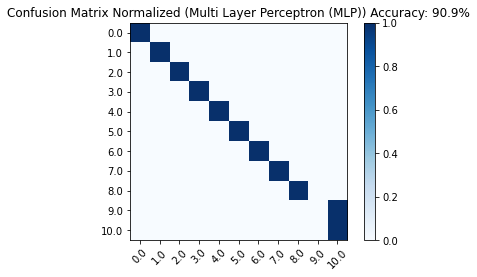

In [15]:
################ Multi-Layer Perceptron ##################
# Train an MLP model on the original features
# first input and output layer and in between 2 hidden layers with 256 and 128 neurons respectively.
mlp = MLPClassifier ()
ml = mlp.fit(X_train_scaled, train_y)

# Compute the predicted labels on test data
y_mlp = ml.predict(X_test_scaled)

#print the accuracy
accuracy = metrics.accuracy_score(test_y, y_mlp)*100
print("Acuracy of Multi-layer Perceptron: {:.2f}".format(accuracy))
# Compute and show confusion matrix
compute_and_plot_cm(test_y, y_mlp, data_class_labels, title="Multi Layer Perceptron (MLP)")